# Going deeper with Tensorflow

In this video, we're going to study the tools you'll use to build deep learning models. Namely, [Tensorflow](https://www.tensorflow.org/).

If you're running this notebook outside the course environment, you'll need to install tensorflow:
* `pip install tensorflow` should install cpu-only TF on Linux & Mac OS
* If you want GPU support from offset, see [TF install page](https://www.tensorflow.org/install/)

In [1]:
import sys
sys.version

'3.6.4 (default, Mar 13 2018, 18:18:20) \n[GCC 7.3.1 20180303 (Red Hat 7.3.1-5)]'

In [2]:
import sys
sys.path.append("..")
import grading

# Visualization

Plase note that if you are running on the Coursera platform, you won't be able to access the tensorboard instance due to the network setup there. If you run the notebook locally, you should be able to access TensorBoard on http://127.0.0.1:7007/

In [41]:
! killall tensorboard
import os
os.system("tensorboard --logdir=/tmp/tboard --port=7007 &");

In [42]:
import tensorflow as tf
s = tf.InteractiveSession()

/usr/local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# Warming up
For starters, let's implement a python function that computes the sum of squares of numbers from 0 to N-1.

In [15]:
import numpy as np
def sum_sin(N):
    return np.sum(np.arange(N)**2)

In [16]:
%%time
sum_sin(10**8)

CPU times: user 379 ms, sys: 866 ms, total: 1.24 s
Wall time: 1.26 s


662921401752298880

# Tensoflow teaser

Doing the very same thing

In [17]:
# An integer parameter
N = tf.placeholder('int64', name="input_to_your_function")

# A recipe on how to produce the same result
result = tf.reduce_sum(tf.range(N)**2)

In [18]:
result

<tf.Tensor 'Sum_1:0' shape=() dtype=int64>

In [19]:
%%time
result.eval({N: 10**8})

CPU times: user 842 ms, sys: 336 ms, total: 1.18 s
Wall time: 700 ms


662921401752298880

In [43]:
writer = tf.summary.FileWriter("/tmp/tboard", graph=s.graph)

# How does it work?
1. Define placeholders where you'll send inputs
2. Make symbolic graph: a recipe for mathematical transformation of those placeholders
3. Compute outputs of your graph with particular values for each placeholder
  * `output.eval({placeholder:value})`
  * `s.run(output, {placeholder:value})`

So far there are two main entities: "placeholder" and "transformation"
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be int32/64, floats, booleans (uint8) of various size.

* You can define new transformations as an arbitrary operation on placeholders and other transformations
 * `tf.reduce_sum(tf.arange(N)**2)` are 3 sequential transformations of placeholder `N`
 * There's a tensorflow symbolic version for every numpy function
   * `a+b, a/b, a**b, ...` behave just like in numpy
   * `np.mean` -> `tf.reduce_mean`
   * `np.arange` -> `tf.range`
   * `np.cumsum` -> `tf.cumsum`
   * If if you can't find the op you need, see the [docs](https://www.tensorflow.org/api_docs/python).
   
`tf.contrib` has many high-level features, may be worth a look.

In [21]:
with tf.name_scope("Placeholders_examples"):
    # Default placeholder that can be arbitrary float32
    # scalar, vertor, matrix, etc.
    arbitrary_input = tf.placeholder('float32')

    # Input vector of arbitrary length
    input_vector = tf.placeholder('float32', shape=(None,))

    # Input vector that _must_ have 10 elements and integer type
    fixed_vector = tf.placeholder('int32', shape=(10,))

    # Matrix of arbitrary n_rows and 15 columns
    # (e.g. a minibatch your data table)
    input_matrix = tf.placeholder('float32', shape=(None, 15))
    
    # You can generally use None whenever you don't need a specific shape
    input1 = tf.placeholder('float64', shape=(None, 100, None))
    input2 = tf.placeholder('int32', shape=(None, None, 3, 224, 224))

    # elementwise multiplication
    double_the_vector = input_vector*2

    # elementwise cosine
    elementwise_cosine = tf.cos(input_vector)

    # difference between squared vector and vector itself plus one
    vector_squares = input_vector**2 - input_vector + 1

In [22]:
my_vector =  tf.placeholder('float32', shape=(None,), name="VECTOR_1")
my_vector2 = tf.placeholder('float32', shape=(None,))
my_transformation = my_vector * my_vector2 / (tf.sin(my_vector) + 1)

In [23]:
print(my_transformation)

Tensor("truediv:0", shape=(?,), dtype=float32)


In [24]:
dummy = np.arange(5).astype('float32')
print(dummy)
my_transformation.eval({my_vector:dummy, my_vector2:dummy[::-1]})

[0. 1. 2. 3. 4.]


array([0.       , 1.6291324, 2.0950115, 2.6289961, 0.       ],
      dtype=float32)

In [25]:
writer.add_graph(my_transformation.graph)
writer.flush()

TensorBoard allows writing scalars, images, audio, histogram. You can read more on tensorboard usage [here](https://www.tensorflow.org/get_started/graph_viz).

# Summary
* Tensorflow is based on computation graphs
* The graphs consist of placehlders and transformations

# Mean squared error

Your assignment is to implement mean squared error in tensorflow.

In [44]:
with tf.name_scope("MSE"):
    y_true = tf.placeholder("float32", shape=(None,), name="y_true")
    y_predicted = tf.placeholder("float32", shape=(None,), name="y_predicted")
    # Your code goes here
    # You want to use tf.reduce_mean
    # mse = tf.<...>
    mse = tf.reduce_mean((y_true - y_predicted) ** 2)
def compute_mse(vector1, vector2):
    return mse.eval({y_true: vector1, y_predicted: vector2})

In [45]:
writer.add_graph(mse.graph)
writer.flush()

Tests and result submission. Please use the credentials obtained from the Coursera assignment page.

In [48]:
import submit

In [49]:
submit.submit_mse(compute_mse, 'orlov.van@gmail.com', '48EWDptT7hsZXYK6')

Submitted to Coursera platform. See results on assignment page!


# Variables

The inputs and transformations have no value outside function call. This isn't too comfortable if you want your model to have parameters (e.g. network weights) that are always present, but can change their value over time.

Tensorflow solves this with `tf.Variable` objects.
* You can assign variable a value at any time in your graph
* Unlike placeholders, there's no need to explicitly pass values to variables when `s.run(...)`-ing
* You can use variables the same way you use transformations 
 

In [27]:
# Creating a shared variable
shared_vector_1 = tf.Variable(initial_value=np.ones(5),
                              name="example_variable")

In [28]:
# Initialize variable(s) with initial values
s.run(tf.global_variables_initializer())

# Evaluating shared variable (outside symbolicd graph)
print("Initial value", s.run(shared_vector_1))

# Within symbolic graph you use them just
# as any other inout or transformation, not "get value" needed

Initial value [1. 1. 1. 1. 1.]


In [29]:
# Setting a new value
s.run(shared_vector_1.assign(np.arange(5)))

# Getting that new value
print("New value", s.run(shared_vector_1))

New value [0. 1. 2. 3. 4.]


# tf.gradients - why graphs matter
* Tensorflow can compute derivatives and gradients automatically using the computation graph
* True to its name it can manage matrix derivatives
* Gradients are computed as a product of elementary derivatives via the chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

It can get you the derivative of any graph as long as it knows how to differentiate elementary operations

In [30]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar**2

# A derivative of scalar_squared by my_scalar
derivative = tf.gradients(scalar_squared, [my_scalar, ])

In [31]:
derivative

[<tf.Tensor 'gradients/pow_2_grad/Reshape:0' shape=<unknown> dtype=float32>]

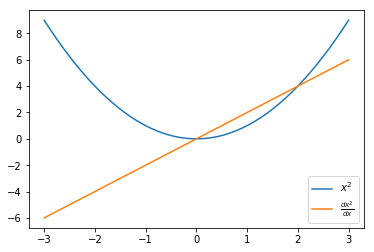

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-3, 3)
x_squared, x_squared_der = s.run([scalar_squared, derivative[0]],
                                 {my_scalar:x})

plt.plot(x, x_squared,label="$x^2$")
plt.plot(x, x_squared_der, label=r"$\frac{dx^2}{dx}$")
plt.legend();

# Why that rocks

In [33]:
my_vector = tf.placeholder('float32', [None])
# Compute the gradient of the next weird function over my_scalar and my_vector
# Warning! Trying to understand the meaning of that function may result in permanent brain damage
weird_psychotic_function = tf.reduce_mean(
    (my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) + 
    1./ tf.atan(my_scalar))/(my_scalar**2 + 1) + 0.01*tf.sin(
    2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2
                      )*tf.exp((my_scalar-4)**2)/(
    1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2)
                                    )/(1+tf.exp(-(my_scalar-4)**2)))**2

der_by_scalar = tf.gradients(weird_psychotic_function, my_scalar)
der_by_vector = tf.gradients(weird_psychotic_function, my_vector)

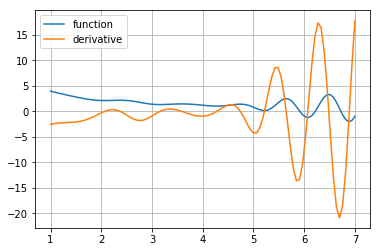

In [34]:
# Plotting the derivative
scalar_space = np.linspace(1, 7, 100)

y = [s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [s.run(der_by_scalar,
                         {my_scalar:x, my_vector:[1, 2, 3]})
                   for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend();

# Almost done - optimizers

While you can perform gradient descent by hand with automatic grads from above, tensorflow also has some optimization methods implemented for you. Recall momentum & rmsprop?

In [35]:
y_guess = tf.Variable(np.zeros(2, dtype='float32'))
y_true = tf.range(1, 3, dtype='float32')
loss = tf.reduce_mean((y_guess - y_true + tf.random_normal([2]))**2) 
#loss = tf.reduce_mean((y_guess - y_true)**2) 
optimizer = tf.train.MomentumOptimizer(0.01, 0.5).minimize(
    loss, var_list=y_guess)

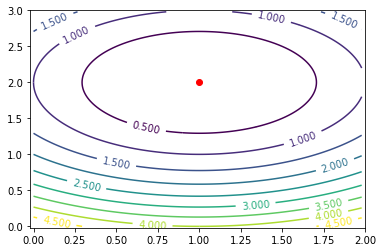

In [36]:
from matplotlib import animation, rc
import matplotlib_utils
from IPython.display import HTML, display_html

fig, ax = plt.subplots()
y_true_value = s.run(y_true)
level_x = np.arange(0, 2, 0.02)
level_y = np.arange(0, 3, 0.02)
X, Y = np.meshgrid(level_x, level_y)
Z = (X - y_true_value[0])**2 + (Y - y_true_value[1])**2
ax.set_xlim(-0.02, 2)
ax.set_ylim(-0.02, 3)
s.run(tf.global_variables_initializer())
ax.scatter(*s.run(y_true), c='red')
contour = ax.contour(X, Y, Z, 10)
ax.clabel(contour, inline=1, fontsize=10)
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

guesses = [s.run(y_guess)]

def animate(i):
    s.run(optimizer)
    guesses.append(s.run(y_guess))
    line.set_data(*zip(*guesses))
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=400, interval=20, blit=True)

In [37]:
try:
    display_html(HTML(anim.to_html5_video()))
# In case the build-in renderers are unaviable, fall back to
# a custom one, that doesn't require external libraries
except RuntimeError:
    anim.save(None, writer=matplotlib_utils.SimpleMovieWriter(0.001))

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAC2rG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQ4IHIyNzk1IGFhYTlhYTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAADJuZYiE
AC///vau/MsrRwuVLh1Ze7NR8uhJcv2IMH1oAAADAADVayF8oYJVUBjg5Cl8UC950wnQObmxLpMS
eTd2N1o7ZvU7nZLqidQWs9IRqH4qZFuUNOvgrgAArGB7WlESNB735J/CfrjEy3i5zjzWx5r7oD4b
7vRGf5YZpSE2SfCltWRnqtLPBS3FxRjhpp/BEdar5txSfEu67R/ppgZwAi2i8ff512MwmU2ndVwZ
0/IypwbXeLiexIGKwjGLSLtuFQ6Y/OKysfXRdbpNhUrKtfRj7DGM8WCX1Bh4c330WAw+R6EXVRFY
lu5UH1qoQzyL4+ViaXbsk9e17GMhYcjYQ2ErNh8GLHqFB5yll7cH5+/ATt414OGqKJBfavN2H7Eo
MYMyQUJm9f6njg6oT6RI9deVwCrdBzM/Sz/x8vLmA7OACvEgs7ec3QswOORd/etOu0E7t7VpiB00
hKHHIDZREnqwvaNj69QpwDqX0pss1cRClh94zlgStU4c5yUCVO+HQbSt4HAXLJj2f9Btb1Gp56ii
Oi96XZV1x4KhUxTYawQAUfjzsl0QevSEuVTVlSNIsvo+7QD/x5dqmV34q8Y/e22ByjofSHxpk/7U
JlOIzg46ZfH1hLZgWW3R/niY7hJcJ7T94UsjfEkSh3TDgfcD17lLYnCY2sdzwQUX/M7yx8DlUAxf
Bf5jCXE+1+wNMg1QAvfybm1SjIO2TPl8BU8XJsElm8w528BUCYhGy7qcnRnuSy6QxEV7zgbX58W4
OX++3kHg9QTGgyx+9vVBAdT1fCClHX4ANSaqmTCW59ftwD0BujqkCCWkUJ2w9uAMrIdCjsnjVQgY
usw2C1nI5upe6qRnHhMYO+//zOhJwy3GFabODqjJ8LP6JD9HicRvbp/KU0u7QNM3PDeCZGEppIp+
d+A0U9LkqJcqlVU9QxjMxe4V5wWiAXVz7X2hUEkcgvbIBu6DDirLSkB6X62ytFi1xHsjrXMwRBoi
23k/4WJeSt9ercxBpim+OztNcFsiesOQP5sSGoW5wkc38yjAPbcq7Tdzbk/IrDDaOdxl5A3HGLvo
zZ1BGOReneHzeHg/afksZWL4VFYt54t3/Hf9K1pP0qpg033ec0POTLSV2EuXudGEW3w0++tbXV/W
TzfL1OHthmmQR6IPVUHFMoqzp1QcXRtQTOdfyzhgBiRX5WVO85tv8+La/kmO0HsSZYHMklOP3co5
QDWHzfJAv2xFzpb4zaWMSFkI64HEJiEbYjDtCz5R+5934JrTITw/HoIDDZMsJDKJDy7tEPbaSA9e
Rs6mLK1h7v5ilXo8fU4zXpoO8DIuXkGCPnMytYPsejoVgG8/4hV+pdupgbZzrYj2YP/KOAfFDlCb
c+Afko28P+APuNw+AREopUusHlOjBttYqMfZpF0lXHnSyZGaC4E/9t+DTsSLLdxT7j02EJ/DJYcg
zlbYlWxHyR67M59DOduDXxQ1yVc6Uv0xHmi8cZyM2klmNgFAuAnAXoBpK89d0ninH4c+/x3zxCND
gVwld+ZkhAQLOdusrHeV3kkduEsmNVMMG/Z4jzBVquh65pjovblc+tWCuZM25L8WnssoH8vTmfqk
8z4vSza/UA18+dAwWnRG9TaD1J9lDGVsI+2H5s+SHVWANZOLLVmeWQLhlKcLusWsnTy4W6Qc1hK3
lWy4lqZwoLwKwRWbX98yP5cBLAAAJoy3FrpsDsUYtE3TL3kuxuFVvIqfYjjoZ3q1MFTJsXRq06LK
CGXjzDp6hB7mkW+cUnSDxxWGDOoq2FRt3I6jf4pVWCtbujN+OSzPO8fJfMPqmvW7za2IZNH4Ivtm
sJzTRzypJjeyJ0gkQxOt04Wtpk9pR8wFijYSlPAPe/xLLPTGlzVe4z/sJ/ZxT0sXez2TFb2HS+PN
5fGrWLRo7iTiPCfUPMNtVVeW8QLshluhtUxaeuzxL4KRaXWDzZPD3oCZy7l7PrHjbnsCu+QniSLg
8rdR9xoYbwUQ5YwHF3/Nci+zL1HxGZ4L2fog8TyKfh5YrePpnYaER/liN4NOXHG3TyRUAHQPEB+O
0fmDCiGW42CFp/SOdacVMu4hEherC3AgxrebXZ6lt57G1D6yYyf/mXSrjlMM6aD8AzMo7YaVi/1Q
riXfAbGXkxyMj9BfJMwbTj+GynyOugQf/Ri8ucxRM1dfn2kFerYby85cHDMQ9lc0dfLgioxLGqWq
oC8rjPsjgmTYbWjjaA5viU+h3WQwUXncbJMFRQhDbme5/pstilZLsiuxC7ZL9VVppiO237u2tvTB
5O/8XFIx0/TJ81Lid1cz77odgSOfPeXtxPbE5SBBn+cjPtwUOxtNkNL/OuX1ZKCfXJ5aiJfNNxEK
D4e+kd6iysnSzitkRlLacXr7s9KBBllv2aI7NxGNNB+3pp85KO0OCRRDsw7GYBJFOmiviotN98fv
2v7QdcgTYb85gFHBdRQSt7HxjJDk/w5CdMPF7EWgfeHzpqvABLah889ax9+imBMblgPrYaNqv1J1
XnKchWA3APyUoBO4qNFdLXG6CZBn1McudnDPTfhmtQIMDDg7aUsx4YK15aB+nq/rZIHoQfXJOdfC
zMFGuZut1ezWPRkPdrfmFbb69AbsqSG8ce5lixqUAxoRYZlB7as0utiunTvSauqfa0rMpUAVXLxh
AvM7ve5ct6bpU3I6pDH2Liipvmm6CJ36P4Q2bErgqNdVz2PS9ebtw9Y5teX/nqV85RZdGzRifMIC
0zU8GUebYKDN9+EEwQxkfCV2fhSi+XMCQCt8OqcFOKfm3Ze0eSfcFeBM2eF9u1QBZnSjM8ujHu1u
ofWurCo3bI4uE7KiiCGiDfZOAahRluwQIip2KprEJVRNXyv+5qrTvRN+1OyIMbbeDZiEm05erue1
k7Dl9uFkfPKCqrzftDROA

# Logistic regression
Your assignment is to implement the logistic regression

Plan:
* Use a shared variable for weights
* Use a matrix placeholder for `X`
 
We shall train on a two-class MNIST dataset
* please note that target `y` are `{0,1}` and not `{-1,1}` as in some formulae

In [50]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X, y = mnist.data, mnist.target

print("y [shape - %s]:" % (str(y.shape)), y[:10])
print("X [shape - %s]:" % (str(X.shape)))

y [shape - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [shape - (360, 64)]:


X:
 [[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0.]
 [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.]
 [ 0.  0.  1.  9. 15. 11.  0.  0.  0.  0.]]
y:
 [0 1 0 1 0 1 0 0 1 1]


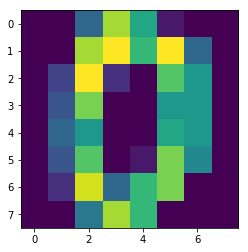

In [51]:
print('X:\n',X[:3,:10])
print('y:\n',y[:10])
plt.imshow(X[0].reshape([8,8]));

It's your turn now!
Just a small reminder of the relevant math:

$$
P(y=1|X) = \sigma(X \cdot W + b)
$$
$$
\text{loss} = -\log\left(P\left(y_\text{predicted} = 1\right)\right)\cdot y_\text{true} - \log\left(1 - P\left(y_\text{predicted} = 1\right)\right)\cdot\left(1 - y_\text{true}\right)
$$

$\sigma(x)$ is available via `tf.nn.sigmoid` and matrix multiplication via `tf.matmul`

In [119]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

__Your code goes here.__ For the training and testing scaffolding to work, please stick to the names in comments.

In [120]:
X.shape

(360, 64)

In [193]:
random.rand()

NameError: name 'random' is not defined

In [176]:
# Model parameters - weights and bias
# weights = tf.Variable(...) shape should be (X.shape[1], 1)
# b = tf.Variable(...)
weights = tf.Variable(initial_value=np.ones(shape=(X.shape[1], 1)), name="weights", dtype='float32')
b = tf.Variable(initial_value=1, name='bias', dtype='float32')

In [177]:
# Placeholders for the input data
# input_X = tf.placeholder(...)
# input_y = tf.placeholder(...)
input_X = tf.placeholder('float32', shape=(None, X.shape[1]), name="input_X")
input_y = tf.placeholder('float32', shape=(None, ), name="input_y")

In [192]:
# The model code

# Compute a vector of predictions, resulting shape should be [input_X.shape[0],]
# This is 1D, if you have extra dimensions, you can  get rid of them with tf.squeeze .
# Don't forget the sigmoid.
# predicted_y = <predicted probabilities for input_X>
#predicted_y = tf.squeeze(tf.nn.sigmoid(tf.matmul(input_X, weights) + b))
predicted_y =  tf.squeeze(tf.nn.sigmoid(tf.matmul(input_X, weights) + b))
#predicted_y = tf.nn.sigmoid(tf.matmul(input_X, weights) + b)
# Loss. Should be a scalar number - average loss over all the objects
# tf.reduce_mean is your friend here
# loss = <logistic loss (scalar, mean over sample)>
loss = tf.reduce_mean(-tf.log(predicted_y) * input_y - tf.log(1 - predicted_y) * (1 - input_y))
#loss = predicted_y

# See above for an example. tf.train.*Optimizer
# optimizer = <optimizer that minimizes loss>
optimizer = tf.train.MomentumOptimizer(0.01, 0.5).minimize(loss, var_list=[weights, b])

A test to help with the debugging

In [179]:
validation_weights = 1e-3 * np.fromiter(map(lambda x:
        s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 0.1, 2]}),
                                   0.15 * np.arange(1, X.shape[1] + 1)),
                                   count=X.shape[1], dtype=np.float32)[:, np.newaxis]
# Compute predictions for given weights and bias
prediction_validation = s.run(
    predicted_y, {
    input_X: X,
    weights: validation_weights,
    b: 1e-1})

# Load the reference values for the predictions
validation_true_values = np.loadtxt("validation_predictons.txt")

assert prediction_validation.shape == (X.shape[0],),\
       "Predictions must be a 1D array with length equal to the number " \
       "of examples in input_X"
assert np.allclose(validation_true_values, prediction_validation)
loss_validation = s.run(
        loss, {
            input_X: X[:100],
            input_y: y[-100:],
            weights: validation_weights+1.21e-3,
            b: -1e-1})
assert np.allclose(loss_validation, 0.728689)

In [180]:
s.run(tf.global_variables_initializer())
loss_i = s.run(loss, {input_X: X_train, input_y: y_train})
print(loss_i)

0.71852165


In [181]:
from sklearn.metrics import roc_auc_score
s.run(tf.global_variables_initializer())
for i in range(5):
    s.run(optimizer, {input_X: X_train, input_y: y_train})
    loss_i = s.run(loss, {input_X: X_train, input_y: y_train})
    print("loss at iter %i:%.4f" % (i, loss_i))
    print("train auc:", roc_auc_score(y_train, s.run(predicted_y, {input_X:X_train})))
    print("test auc:", roc_auc_score(y_test, s.run(predicted_y, {input_X:X_test})))

loss at iter 0:0.5376
train auc: 1.0
test auc: 1.0
loss at iter 1:0.3646
train auc: 0.9998902064119456
test auc: 0.999505928853755
loss at iter 2:0.0182
train auc: 1.0
test auc: 1.0
loss at iter 3:0.0100
train auc: 1.0
test auc: 1.0
loss at iter 4:0.0125
train auc: 1.0
test auc: 1.0


### Coursera submission

In [182]:
grade_submitter = grading.Grader("BJCiiY8sEeeCnhKCj4fcOA")

In [183]:
test_weights = 1e-3 * np.fromiter(map(lambda x:
    s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]}),
                               0.1 * np.arange(1, X.shape[1] + 1)),
                               count=X.shape[1], dtype=np.float32)[:, np.newaxis]

First, test prediction and loss computation. This part doesn't require a fitted model.

In [184]:
prediction_test = s.run(
    predicted_y, {
    input_X: X,
    weights: test_weights,
    b: 1e-1})

In [185]:
assert prediction_test.shape == (X.shape[0],),\
       "Predictions must be a 1D array with length equal to the number " \
       "of examples in X_test"

In [186]:
grade_submitter.set_answer("0ENlN", prediction_test)

In [187]:
loss_test = s.run(
    loss, {
        input_X: X[:100],
        input_y: y[-100:],
        weights: test_weights+1.21e-3,
        b: -1e-1})
# Yes, the X/y indices mistmach is intentional

In [188]:
grade_submitter.set_answer("mMVpM", loss_test)

In [189]:
grade_submitter.set_answer("D16Rc", roc_auc_score(y_test, s.run(predicted_y, {input_X:X_test})))

Please use the credentials obtained from the Coursera assignment page.

In [190]:
grade_submitter.submit('orlov.van@gmail.com', '2TbCn3RNEJyAXQGE')

Submitted to Coursera platform. See results on assignment page!
